In [1]:
import os

import numpy as np
import pandas as pd

from natsort import natsorted

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.ticker import MultipleLocator        

In [2]:
# I/O
main = pd.read_csv(os.path.join(os.getcwd(), 'input/main.csv'))  

out = os.path.join(os.getcwd(), 'output/cells_per_patch')
if not os.path.exists(out):
    os.makedirs(out)

> /var/folders/_h/pbzrx8ss6n5f031pf4hc97_w0000gp/T/ipykernel_67671/2591541134.py(81)<module>()
     79 
     80         # increase x-tick frequency
---> 81         g.axes.xaxis.set_major_locator(MultipleLocator(10))
     82 
     83         g.set_xlabel('% patches', fontsize=15)



ipdb>  plot


        Window Size: 14x14 pixels  Cell Count   Q1   Q3  IQR
0                               1           1  1.0  1.0  0.0
1                               1           2  1.0  1.0  0.0
2                               1           1  1.0  1.0  0.0
3                               1           1  1.0  1.0  0.0
4                               1           1  1.0  1.0  0.0
...                           ...         ...  ...  ...  ...
479904                          1           1  1.0  1.0  0.0
479905                          1           1  1.0  1.0  0.0
479906                          1           1  1.0  1.0  0.0
479907                          1           1  1.0  1.0  0.0
479908                          1           2  1.0  1.0  0.0

[479909 rows x 5 columns]


ipdb>  plot[plot['Cell Count'] == 1]


        Window Size: 14x14 pixels  Cell Count   Q1   Q3  IQR
0                               1           1  1.0  1.0  0.0
2                               1           1  1.0  1.0  0.0
3                               1           1  1.0  1.0  0.0
4                               1           1  1.0  1.0  0.0
5                               1           1  1.0  1.0  0.0
...                           ...         ...  ...  ...  ...
479903                          1           1  1.0  1.0  0.0
479904                          1           1  1.0  1.0  0.0
479905                          1           1  1.0  1.0  0.0
479906                          1           1  1.0  1.0  0.0
479907                          1           1  1.0  1.0  0.0

[365078 rows x 5 columns]


ipdb>  plot[plot['Cell Count'] == 1].sum()


Window Size: 14x14 pixels    365078.0
Cell Count                   365078.0
Q1                           365078.0
Q3                           365078.0
IQR                               0.0
dtype: float64


ipdb>  plot


        Window Size: 14x14 pixels  Cell Count   Q1   Q3  IQR
0                               1           1  1.0  1.0  0.0
1                               1           2  1.0  1.0  0.0
2                               1           1  1.0  1.0  0.0
3                               1           1  1.0  1.0  0.0
4                               1           1  1.0  1.0  0.0
...                           ...         ...  ...  ...  ...
479904                          1           1  1.0  1.0  0.0
479905                          1           1  1.0  1.0  0.0
479906                          1           1  1.0  1.0  0.0
479907                          1           1  1.0  1.0  0.0
479908                          1           2  1.0  1.0  0.0

[479909 rows x 5 columns]


ipdb>  365078/479909


0.7607233871421457


ipdb>  (365078/479909)*100


76.07233871421457


ipdb>  exit


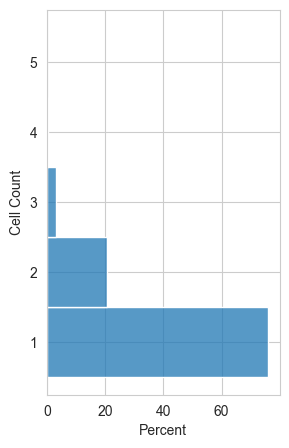

In [3]:
# generate boxen plots of the distribution of nuclei for VAE9 and VAE20 image patches
for window_size in [14, 30]:  # in square pixels

    if not os.path.exists(os.path.join(out, f'counts{window_size}.csv')):

        print(f'Working on window size {window_size}.')
        
        radius = window_size / 2
        
        counts = []
        for i, j in main.iterrows():
            if i % 10000 == 0:
                print(i)
            
            # isolate cells in window_size x window_size pixel area and 
            # append nuclei count to counts list
            x = j['X_centroid']
            y = j['Y_centroid']
            patch = (
                main[(main['Y_centroid'].between(y - radius, y + radius)) &
                        (main['X_centroid'].between(x - radius, x + radius))].copy()
            )
            counts.append(len(patch))

        plot = pd.DataFrame(
            data={f'Window Size: {window_size}x{window_size} pixels': 1, 'Cell Count': counts}
        )

        q1, q3 = np.percentile(plot['Cell Count'], [25, 75])
        iqr = q3 - q1
        plot['Q1'] = q1
        plot['Q3'] = q3
        plot['IQR'] = iqr

        plot.to_csv(os.path.join(out, f'counts{window_size}.csv'), index=False)
        
        plt.rcParams['font.family'] = 'Arial'
        sns.set_style('whitegrid')

        fig, ax = plt.subplots(figsize=(3,5)) 
        
        g = sns.histplot(data=plot,y='Cell Count', discrete=True, stat='percent')

        # increase x-tick frequency
        g.axes.xaxis.set_major_locator(MultipleLocator(10))

        g.set_xlabel('% patches', fontsize=15)
        g.set_ylabel('# nuclei', fontsize=15)
        
        plt.xticks(fontsize=11)
        plt.yticks(fontsize=11)
        
        # annotate median value on the boxen plot
        # median = plot['Cell Count'].median()
        # plt.axhline(y=median, color='red', linestyle='-', linewidth=2)

        plt.tight_layout()
        plt.savefig(os.path.join(out, f'patch_counts_w{window_size}.pdf'))
        plt.show()
        plt.close('all')
        print()
    
    else:  # if counts.csv has already been saved
        
        plot = pd.read_csv(os.path.join(out, f'counts{window_size}.csv'))

        plt.rcParams['font.family'] = 'Arial'
        sns.set_style('whitegrid')
        
        fig, ax = plt.subplots(figsize=(3,5))
        

        g = sns.histplot(data=plot,y='Cell Count', discrete=True, stat='percent')
        
        # Get the heights of the bars (counts)
        heights = [patch.get_height() for patch in g.patches]
        import pdb; pdb.set_trace()
        
        
        # increase x-tick frequency
        g.axes.xaxis.set_major_locator(MultipleLocator(10))
        
        g.set_xlabel('% patches', fontsize=15)
        g.set_ylabel('# nuclei', fontsize=15)
        
        plt.xticks(fontsize=11)
        plt.yticks(fontsize=11)
        
        # annotate median value on the boxen plot
        # median = plot['Cell Count'].median()
        # plt.axhline(y=median, color='red', linestyle='-', linewidth=2)

        plt.tight_layout()
        plt.savefig(os.path.join(out, f'patch_counts_w{window_size}.pdf'))
        plt.show()
        plt.close('all')
        print()

In [ ]:
# generate boxen plots of the distribution of nuclei per VAE9 image patch cluster
window_size = 14
radius = window_size / 2

counts = []
means = {}  # dict of mean nuceli values for bar plot below

for clus in natsorted(main['VAE9_ROT_VIG18'].unique()):
    
    print(f'Working on cluster {clus} with window size {window_size}.')
    
    subset = main[main['VAE9_ROT_VIG18'] == clus]
    
    if not os.path.exists(os.path.join(out, f'counts{window_size}_cluster{clus}.csv')):
        
        subset = main[main['VAE9_ROT_VIG18'] == clus]
        subset.reset_index(inplace=True)
        
        for i, j in subset.iterrows():
            if i % 10000 == 0:
                print(i)
            
            # isolate cells in window_size x window_size pixel area and 
            # append nuclei count to counts list
            x = j['X_centroid']
            y = j['Y_centroid']
            patch = (
                main[(main['Y_centroid'].between(y - radius, y + radius)) &
                        (main['X_centroid'].between(x - radius, x + radius))].copy()
            )
            counts.append(len(patch))
    
        plot = pd.DataFrame(
            data={f'Window Size: {window_size}x{window_size} pixels': 1, 'Cell Count': counts}
        )
        
        means[clus] = [plot['Cell Count'].mean()]
        
        q1, q3 = np.percentile(plot['Cell Count'], [25, 75])
        iqr = q3 - q1
        plot['Q1'] = q1
        plot['Q3'] = q3
        plot['IQR'] = iqr
    
        plot.to_csv(os.path.join(out, f'counts{window_size}_cluster{clus}.csv'), index=False)
        
        plt.rcParams['font.family'] = 'Arial'
        sns.set_style('whitegrid')

        fig, ax = plt.subplots(figsize=(3,5))

        g = sns.histplot(
            data=plot,y='Cell Count', discrete=True, stat='percent', binwidth=10
        )
       
        # increase x-tick frequency
        g.axes.xaxis.set_major_locator(MultipleLocator(10))
        
        g.set_xlabel('% patches', fontsize=15)
        g.set_ylabel('# nuclei', fontsize=15)
        
        plt.xticks(fontsize=11)
        plt.yticks(fontsize=11)
        
        # annotate median value on the boxen plot
        # median = plot['Cell Count'].median()
        # plt.axhline(y=median, color='red', linestyle='-', linewidth=2)
        
        plt.tight_layout()
        plt.savefig(os.path.join(out, f'patch_counts_w{window_size}_cluster{clus}.pdf'))
        plt.close('all')

    else:  # if counts.csv for current cluster has already been saved
            
        plot = pd.read_csv(os.path.join(out, f'counts{window_size}_cluster{clus}.csv'))
        
        means[clus] = [plot['Cell Count'].mean()]
        
        plt.rcParams['font.family'] = 'Arial'
        sns.set_style('whitegrid')

        fig, ax = plt.subplots(figsize=(3,5))
        
        g = sns.histplot(
            data=plot,y='Cell Count', discrete=True, stat='percent', binwidth=10
        )

        # increase x-tick frequency
        g.axes.xaxis.set_major_locator(MultipleLocator(10))

        g.set_xlabel('% patches', fontsize=15)
        g.set_ylabel('# nuclei', fontsize=15)
        
        plt.xticks(fontsize=11)
        plt.yticks(fontsize=11)
        
        # annotate median value on the boxen plot
        # median = plot['Cell Count'].median()
        # plt.axhline(y=median, color='red', linestyle='-', linewidth=2)
        
        plt.tight_layout()
        plt.savefig(os.path.join(out, f'patch_counts_w{window_size}_cluster{clus}.pdf'))
        plt.close('all')

# convert means dict to a dataframe and save
means_df = pd.DataFrame.from_dict(means, orient='index')
means_df.to_csv(os.path.join(out, f'cluster_cell_count_means.csv'), index=True)

In [ ]:
# generate bar plot of mean nuclei values per VAE9 image patch

# read mean nuclei value dataframe
means_df = pd.read_csv(os.path.join(out, 'cluster_cell_count_means.csv'), index_col=0)
means_df = round(means_df, 3)
means_df = pd.Series(means_df['0'])

# sort by mean values in ascending order, then by index
def custom_sort_key(item):
    return (-item[1], item[0])
means_df = sorted(means_df.items(), key=custom_sort_key)
means_df = pd.Series([item[1] for item in means_df], index=[item[0] for item in means_df])
means_df.sort_values(ascending=True, inplace=True)

# clusters associated with epithelial, immune, and stromal cells
epithelial = [24, 25, 20, 14, 31, 9, 10, 3, 5, 6, 11, 15, 19, 27, 28] 
immune = [26, 30, 8, 12, 16, 21, 7, 2, 22]
stromal = [1, 4, 13, 18, 29, 0, 17, 23]

# color LUT
mpp_colors = {}
mpp_colors.update({str(k): v for k, v in zip(epithelial, ['tab:blue']*len(epithelial))})
mpp_colors.update({str(k): v for k, v in zip(immune, ['tab:orange']*len(immune))})
mpp_colors.update({str(k): v for k, v in zip(stromal, ['tab:green']*len(stromal))})

# plot
fig, ax = plt.subplots(figsize=(15,4))
ax.bar(
    x=[str(i) for i in means_df.index], height=np.log(means_df.values),
    color=[mpp_colors[str(i)] for i in means_df.index], alpha=0.5, width=0.9
)
plt.ylabel('Mean nuclei per patch', fontsize=18)
plt.xlabel('Cluster',fontsize=22, labelpad=15)
ticks = plt.xticks(fontsize=18)

patches = [
    Patch(facecolor=color, alpha=0.5, edgecolor=None) for color in ['tab:blue', 'tab:orange', 'tab:green']
    ]
plt.legend(
    patches, ['epithelial', 'immune', 'stromal'],
    title=None, prop={'size': 10.5},
    labelspacing=0.01, bbox_to_anchor=[1.1, 1.03], loc='upper right'
    )
plt.grid(False)

plt.tight_layout()
plt.savefig(os.path.join(out, f'cluster_cell_count_means.pdf'))
plt.show()
plt.close('all')